# YOUTH PERCEPTION OF SEXUAL EDUCATION IN INDIA

In [1]:
#!pip install pyLDAvis
#!pip install wordcloud
from collections import Counter
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
import numpy as np
import os
import pandas as pd
import pyLDAvis.sklearn
import re
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import spacy
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Where am I?
%pwd

'/Users/anushasubramanian/Desktop/Project101'

In [3]:
survey = pd.read_csv("Education_survey.csv")
del survey["Add Comments"]

In [4]:
survey.head()

,Timestamp,Age,Gender Identity,Sexuality,Religious Affiliation,High School Attended,High School City,School Zipcode,High School Grad Year,Education Level,...,Extent Bullying,Extent Sex Ed,Extent Gender Identity,Extent Menstruation,Extent Finplan,Extent Landscape,Extent Cyber Crime,Sexual Policing,Free Response,Perceived Benefit
0,5/8/2020 18:36:22,21,Female,Heterosexual,Spiritual,"AVM - Mumbai, JNIS - Mumbai, USC - Los Angeles",Mumbai,40050,2015,Bachelor's,...,Occasionally,Occasionally,Never,Never,Rarely,Rarely,Rarely,Maybe,In India (Mumbai) it was introduced very brief...,It will definitely make a difference
1,5/8/2020 18:37:12,19,Male,bisexual,Atheist,Calcutta International School -Till 7th grade ...,"Calcutta, Dehradun",248001,2016,Bachelor's,...,Rarely,Rarely,Never,Never,Rarely,Occasionally,Frequently,Yes,"Being in an all-boys school, I think they took...",It will definitely make a difference
2,5/8/2020 18:40:06,19,Female,Heterosexual,Agnostic,AVM,Mumbai,400050,2016,Bachelor's,...,Rarely,Never,Never,Never,Rarely,Never,Never,Yes,Not well,It could make a difference
3,5/8/2020 18:41:39,19,Female,Heterosexual,Religious,"Arya Vidya Mandir BW , Mumbai. Pace science ju...",Mumbai,400050,2016,Bachelor's,...,Frequently,Rarely,Never,Rarely,Rarely,Never,Rarely,Yes,It was a brief and short seminar that just hig...,It will definitely make a difference
4,5/8/2020 18:42:42,19,Female,Heterosexual,Religious,"Beacon high, JNIS - IB (Mumbai)",Mumbai,400052,2016,Bachelor's,...,Rarely,Never,Never,Never,Never,Never,Rarely,Yes,Schools merely did this in order to justify th...,It will definitely make a difference


# DEMOGRAPHIC DATA 

# Age & High School City

In [5]:
#extract unique age data from survey
age = dict(survey["Age"].value_counts())
age_df = pd.DataFrame()
age_df["age"] = age.keys()
age_df["frequency"] = age.values()

#extract and clean location data 
city = dict(survey["High School City"].value_counts())
city["Dehradun"] = city["Dehradun "] + city["Calcutta, Dehradun "] + city["Doon"]
del city["Dehradun "], city["Calcutta, Dehradun "], city["Doon"]
city_df = pd.DataFrame()
city_df["City"] = city.keys()
city_df["Frequency"] = city.values()

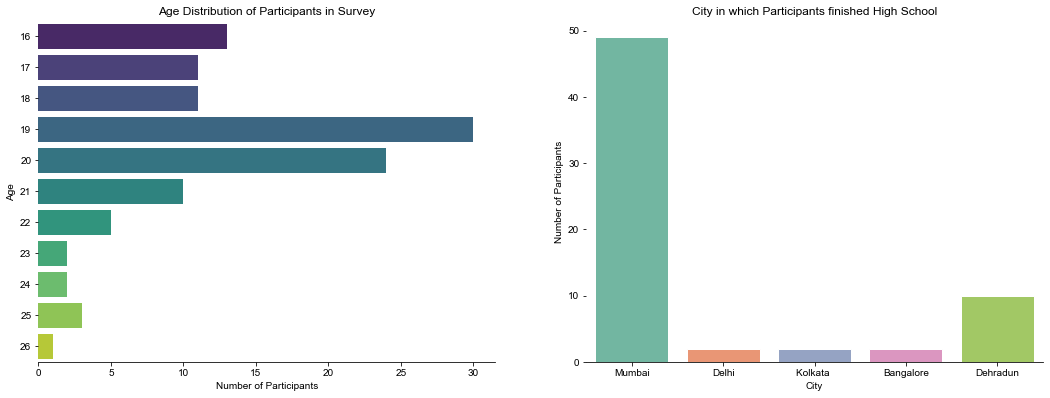

In [6]:
f, axes = plt.subplots(1, 2, figsize =(18,6.27))
                      
#plot age data
#sns.set(rc={'figure.figsize':(10,6.27)})
age_barplot = sns.barplot(x = "frequency", 
                         y = "age", 
                         data = age_df, 
                         orient = "h", palette = 'viridis', ax = axes[0])

age_barplot.set(xlabel = "Number of Participants", ylabel = "Age", title = "Age Distribution of Participants in Survey");

#plot location data
sns.set(rc={'figure.figsize':(10,6.27)})
city_barplot = sns.barplot(x = "City", 
                         y = "Frequency", 
                         data = city_df, 
                         orient = "v", palette = 'Set2', ax = axes[1])
city_barplot.set(xlabel = "City", ylabel = "Number of Participants", title = "City in which Participants finished High School");

sns.despine(left=True)

# Gender 

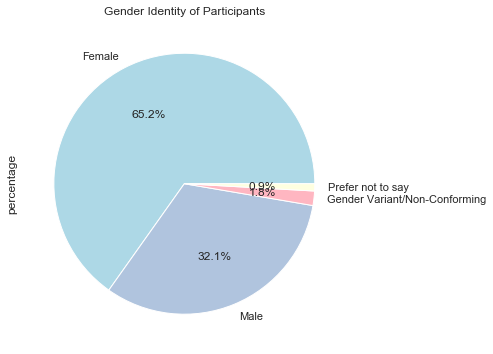

In [7]:
#extract gender data
gender_df = pd.DataFrame(index = ['Female','Male','Gender Variant/Non-Conforming', 'Prefer not to say'])
freq = list(survey["Gender Identity"].value_counts())
gender_df["percentage"] = freq

#plot gender pie chart
gender_pie = gender_df.plot.pie(y = "percentage", figsize = (6,6), autopct ='%1.1f%%',
                             colors = ["lightblue","lightsteelblue", "lightpink", "lightyellow"], legend = False);
plt.title("Gender Identity of Participants");

# Religious Affiliations

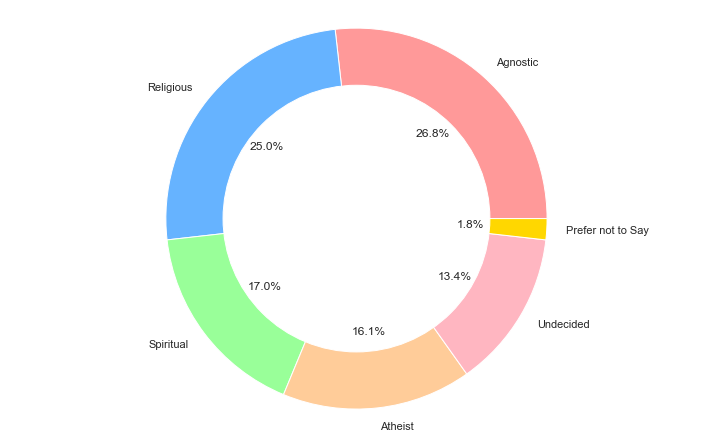

In [8]:
# Pie chart (MEDIUM ARTICLE)

religion = dict(survey["Religious Affiliation "].value_counts())

#Cleaning up repeat data in the survey 
religion["Undecided"] = religion["Still in the process of understanding concept of religion and god"] + religion["No clue "]
del religion["Still in the process of understanding concept of religion and god"], religion["No clue "]

#define variables for the pie-chart
sizes = list(religion.values())
labels = ["Agnostic","Religious","Spiritual","Atheist","Undecided","Prefer not to Say"]

#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','lightpink',"gold"]
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%')

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Which topics were rated the highest?

The survey asked participants to rate the importance of including the topics listed below in their school curriculum, on a 0-5 point scale. The graph depicts the cumulative score after summing the score by indivudual participants. The topic labels have been abbreviated to increase readability and clean code. 

#### Comprehensive Topic List:

1. svsh : Sexual/Domestic Violence and Identifying Workplace Harassment
2. mental_health : Comprehensive Mental Health Awareness, Assessments & Resources
3. bullying : Tackling Bullying & Identifying Toxic Environments
4. sex_ed : Comprehensive Sex Education beyond basic reproduction (safe sex, consent, pleasure, desire)
5. gender_identity : Gender Identity & Sexuality
6. menstruation : Normalization of Menstruation
7. cyber_crime : Comprehensive understanding of Cyber Etiquettes, Crimes, Laws

In [9]:
#sum the columns
ratings = pd.DataFrame()
topics = ["svsh","mental_health","bullying","sex_ed","gender_identity","menstruation","cyber_crime"]
freq = [survey["Imp SVSH"].sum(),survey["Imp Mental Health"].sum(),survey["Imp Bullying"].sum(),survey["Imp Sex Ed"].sum(),
        survey["Imp Gender Identity "].sum(),survey["Imp Menstruation"].sum(),survey["Imp Cyber Crime"].sum()]
ratings["topics"] = topics
ratings["score"] = freq
ratings.sort_values(by = 'score', inplace = True, ascending = False)

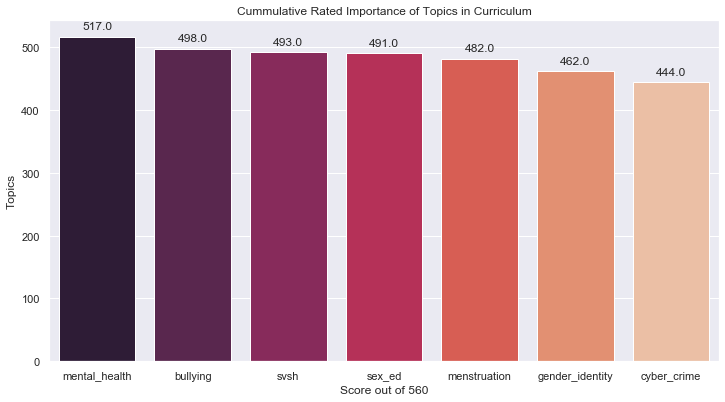

In [15]:
#plot barplot
sns.set(rc={'figure.figsize':(12,6.27)})
imp_barplot = sns.barplot(x = "topics", y = "score", data = ratings, palette = 'rocket', orient = "v");
imp_barplot.set(xlabel = "Score out of 560", ylabel = "Topics", 
                title ="Cummulative Rated Importance of Topics in Curriculum");
for p in imp_barplot.patches:
    imp_barplot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# How often were these topics addressed in School?

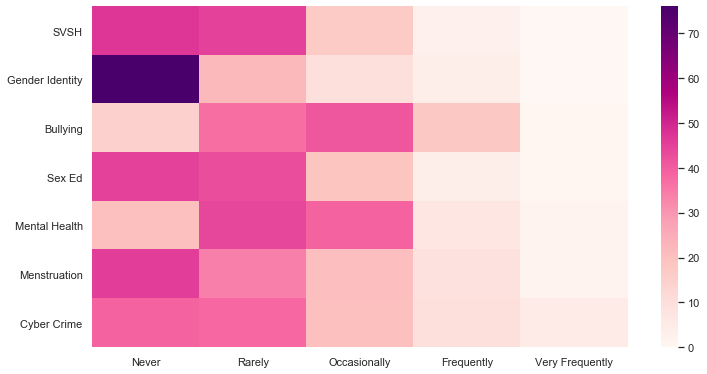

In [83]:
topics = ["SVSH", "Mental Health", "Bullying", "Sex Ed","Gender Identity", "Menstruation", "Cyber Crime"]
metric = ["Never","Rarely","Occasionally","Frequently","Very Frequently"]

#initialise DataFrame
matrix_df = pd.DataFrame(index = topics)

never,rarely, occasionally, freq, vfreq = [],[],[],[],[]

#column numbers we want to extract from survey
columns = [20,21,22,23,24,25,28]

#our data is not tidy. This loop is to create a frequency matrix of the form topicx x metrics
for i in columns:
    count = dict(survey[survey.columns[i]].value_counts())
    for j in metric:
        if j not in count.keys():
            count[j] = 0     
    never.append(count["Never"])
    rarely.append(count["Rarely"])
    occasionally.append(count["Occasionally"])
    freq.append(count["Frequently"])
    vfreq.append(count["Very Frequently"])

# add data to your DataFrame
matrix_df["Never"] = never 
matrix_df["Rarely"] = rarely 
matrix_df["Occasionally"] = occasionally
matrix_df["Frequently"] = freq
matrix_df["Very Frequently"] = vfreq
matrix_df.sort_values(by = "Very Frequently", inplace = True, ascending = True)
matrix_df

sns.heatmap(matrix_df,cmap = 'RdPu');

# Have you experienced Sexual Policing?

In [118]:
#sorting based on gender and sexual policing
gen = survey.iloc[:,[2,29]]
yes = gen.loc[gen["Sexual Policing "] == "Yes"]
yes_dict = dict(yes["Gender Identity"].value_counts())

maybe = gen.loc[gen["Sexual Policing "] == "Maybe"]
m_dict = dict(maybe["Gender Identity"].value_counts())

no = gen.loc[gen["Sexual Policing "] == "No"]
no_dict = dict(no["Gender Identity"].value_counts())

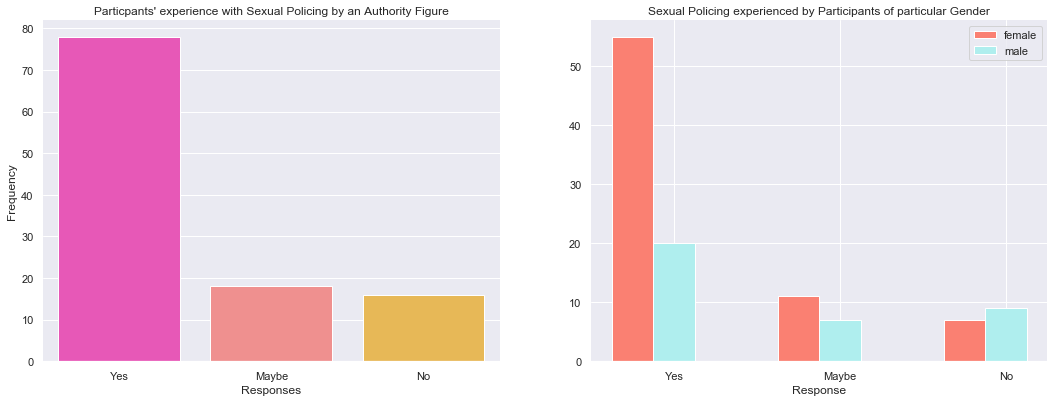

In [172]:
f, axes = plt.subplots(1, 2, figsize =(18,6.27))
# plot raw sexual policing data
police_df = pd.DataFrame()
policing = dict(survey["Sexual Policing "].value_counts())
police_df["Responses"] = policing.keys()
police_df["Frequency"] = policing.values()
police_bar = sns.barplot(x = "Responses",y = "Frequency", data = police_df, orient = "v", palette = 'spring', ax = axes[0])
police_bar.set(title = "Particpants' experience with Sexual Policing by an Authority Figure");


# plot gender specific data

bars1 = [yes_dict['Female'],m_dict['Female'],no_dict['Female']] #female
bars2 = [yes_dict['Male'],m_dict['Male'],no_dict['Male']] #male
plt.bar(r1, bars1, color='salmon', width=0.25,label='female')
plt.bar(r2, bars2, color='paleturquoise', width=0.25, label='male')
plt.legend()
 
# Add xticks on the middle of the group bars
plt.xlabel('Response')
plt.xticks([r + 0.25 for r in range(len(bars1))], ['Yes', 'Maybe', 'No'])
plt.title("Sexual Policing experienced by Participants of particular Gender")

sns.despine(left=True)

In [5]:
response = list(survey["Free Response"])
response[0:2]

['In India (Mumbai) it was introduced very briefly and done in a manner that boys and girls had separate trainings. This sort of defeated the point of normalizing sex related topics as we were not allowed to discuss it freely. In LA, these topics were more normalized (especially via mandatory trainings and online courses that had to be fulfilled prior to beginning freshman year courses).',
 'Being in an all-boys school, I think they took this pretty casually as it was so commonplace.']

In [6]:
#remove punctuations and save in new list
from string import punctuation
text_processed = []
for r in response:
    for char in punctuation:
        r = r.lower().replace(char,"")
    text_processed.append(r)
text_processed[0:2]

['in india mumbai it was introduced very briefly and done in a manner that boys and girls had separate trainings this sort of defeated the point of normalizing sex related topics as we were not allowed to discuss it freely in la these topics were more normalized especially via mandatory trainings and online courses that had to be fulfilled prior to beginning freshman year courses',
 'being in an allboys school i think they took this pretty casually as it was so commonplace']

In [7]:
#add the processed text to our dataframe for use later
survey["Text processed"] = text_processed
survey.head()

,Timestamp,Age,Gender Identity,Sexuality,Religious Affiliation,High School Attended,High School City,School Zipcode,High School Grad Year,Education Level,...,Extent Sex Ed,Extent Gender Identity,Extent Menstruation,Extent Finplan,Extent Landscape,Extent Cyber Crime,Sexual Policing,Free Response,Perceived Benefit,Text processed
0,5/8/2020 18:36:22,21,Female,Heterosexual,Spiritual,"AVM - Mumbai, JNIS - Mumbai, USC - Los Angeles",Mumbai,40050,2015,Bachelor's,...,Occasionally,Never,Never,Rarely,Rarely,Rarely,Maybe,In India (Mumbai) it was introduced very brief...,It will definitely make a difference,in india mumbai it was introduced very briefly...
1,5/8/2020 18:37:12,19,Male,bisexual,Atheist,Calcutta International School -Till 7th grade ...,"Calcutta, Dehradun",248001,2016,Bachelor's,...,Rarely,Never,Never,Rarely,Occasionally,Frequently,Yes,"Being in an all-boys school, I think they took...",It will definitely make a difference,being in an allboys school i think they took t...
2,5/8/2020 18:40:06,19,Female,Heterosexual,Agnostic,AVM,Mumbai,400050,2016,Bachelor's,...,Never,Never,Never,Rarely,Never,Never,Yes,Not well,It could make a difference,not well
3,5/8/2020 18:41:39,19,Female,Heterosexual,Religious,"Arya Vidya Mandir BW , Mumbai. Pace science ju...",Mumbai,400050,2016,Bachelor's,...,Rarely,Never,Rarely,Rarely,Never,Rarely,Yes,It was a brief and short seminar that just hig...,It will definitely make a difference,it was a brief and short seminar that just hig...
4,5/8/2020 18:42:42,19,Female,Heterosexual,Religious,"Beacon high, JNIS - IB (Mumbai)",Mumbai,400052,2016,Bachelor's,...,Never,Never,Never,Never,Never,Rarely,Yes,Schools merely did this in order to justify th...,It will definitely make a difference,schools merely did this in order to justify th...


In [8]:
# Save the "Text_processed" list as one long string
long_string = ','.join(text_processed)
long_string

'in india mumbai it was introduced very briefly and done in a manner that boys and girls had separate trainings this sort of defeated the point of normalizing sex related topics as we were not allowed to discuss it freely in la these topics were more normalized especially via mandatory trainings and online courses that had to be fulfilled prior to beginning freshman year courses,being in an allboys school i think they took this pretty casually as it was so commonplace,not well,it was a brief and short seminar that just highlighted the important points related to the topic discussed frankly those sessions could have been conducted much better,schools merely did this in order to justify their inclusion of nonacademic subjects in the curriculum without actually acknowledging the importance of teaching them this was reflected in their inefficiency  inability to actually teach or convey what they tried to to furthermore teachers and staff themselves were too conservative  unaware  uncomfort

### Lemmatize too please

In [9]:
#Tokenize long string
es_tokens = long_string.split()
#Remove stop words
stop = stopwords.words("english")
no_stop = [word for word in es_tokens if word not in stop]
copy = no_stop
freq_es = Counter(no_stop)
#Print 20 most frequent words
df_es = pd.DataFrame(freq_es.most_common(20), columns = ["Word", "Frequency"])
df_es

#Interesting top three words

,Word,Frequency
0,school,35
1,topics,31
2,never,21
3,girls,17
4,students,14
5,think,13
6,teachers,11
7,discussed,10
8,us,10
9,boys,9


In [10]:
# Define an empty bag (of words)
vectorizer = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vectorizer.fit(survey["Text processed"])

# Print the vocabulary
vectorizer.vocabulary_

{'in': 355,
 'india': 364,
 'mumbai': 456,
 'it': 386,
 'was': 780,
 'introduced': 381,
 'very': 771,
 'briefly': 86,
 'and': 31,
 'done': 200,
 'manner': 427,
 'that': 706,
 'boys': 83,
 'girls': 295,
 'had': 313,
 'separate': 601,
 'trainings': 740,
 'this': 719,
 'sort': 646,
 'of': 485,
 'defeated': 174,
 'the': 708,
 'point': 530,
 'normalizing': 478,
 'sex': 610,
 'related': 565,
 'topics': 733,
 'as': 42,
 'we': 785,
 'were': 792,
 'not': 480,
 'allowed': 25,
 'to': 727,
 'discuss': 191,
 'freely': 281,
 'la': 399,
 'these': 714,
 'more': 449,
 'normalized': 477,
 'especially': 233,
 'via': 772,
 'mandatory': 426,
 'online': 494,
 'courses': 157,
 'be': 64,
 'fulfilled': 284,
 'prior': 540,
 'beginning': 68,
 'freshman': 282,
 'year': 816,
 'being': 70,
 'an': 30,
 'allboys': 24,
 'school': 587,
 'think': 718,
 'they': 715,
 'took': 731,
 'pretty': 537,
 'casually': 104,
 'so': 637,
 'commonplace': 127,
 'well': 790,
 'brief': 85,
 'short': 618,
 'seminar': 596,
 'just': 391,
 '

In [11]:
# Encode the documents
vector = vectorizer.transform(survey["Text processed"])
print(vector) #
#
#
#
#
print(vector.shape)
print(type(vector))

  (0, 25)	1
  (0, 31)	3
  (0, 42)	1
  (0, 64)	1
  (0, 68)	1
  (0, 83)	1
  (0, 86)	1
  (0, 157)	2
  (0, 174)	1
  (0, 191)	1
  (0, 200)	1
  (0, 233)	1
  (0, 281)	1
  (0, 282)	1
  (0, 284)	1
  (0, 295)	1
  (0, 313)	2
  (0, 355)	3
  (0, 364)	1
  (0, 381)	1
  (0, 386)	2
  (0, 399)	1
  (0, 426)	1
  (0, 427)	1
  (0, 449)	1
  :	:
  (110, 480)	1
  (110, 485)	1
  (110, 490)	1
  (110, 509)	1
  (110, 587)	1
  (110, 614)	1
  (110, 672)	1
  (110, 713)	1
  (110, 733)	2
  (110, 757)	1
  (110, 792)	2
  (110, 799)	1
  (110, 817)	1
  (111, 2)	1
  (111, 265)	1
  (111, 283)	1
  (111, 311)	1
  (111, 313)	1
  (111, 405)	1
  (111, 650)	1
  (111, 725)	2
  (111, 727)	1
  (111, 733)	1
  (111, 785)	1
  (111, 798)	1
(112, 823)
<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
# View as a multidimensional array before converting to data frame
# Rows are the documents
# Columns are the terms
print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [13]:
# What are the terms?
vectorizer.get_feature_names()

['ability',
 'able',
 'about',
 'above',
 'academics',
 'accepted',
 'accolades',
 'acknowledging',
 'action',
 'actions',
 'actually',
 'additional',
 'additionally',
 'addressed',
 'addressing',
 'adults',
 'affects',
 'affiliated',
 'aforementioned',
 'after',
 'again',
 'against',
 'age',
 'all',
 'allboys',
 'allowed',
 'alma',
 'also',
 'always',
 'am',
 'an',
 'and',
 'any',
 'anyone',
 'appointed',
 'appreciation',
 'approached',
 'appropriately',
 'are',
 'aren',
 'arent',
 'around',
 'as',
 'asked',
 'aspects',
 'assemblies',
 'assembly',
 'assume',
 'at',
 'attacked',
 'attention',
 'authorities',
 'authority',
 'avoid',
 'avoided',
 'aware',
 'awareness',
 'away',
 'awfully',
 'awkward',
 'bad',
 'badly',
 'barely',
 'basic',
 'be',
 'because',
 'been',
 'before',
 'beginning',
 'behavior',
 'being',
 'believe',
 'believed',
 'best',
 'better',
 'between',
 'big',
 'biology',
 'blind',
 'board',
 'books',
 'both',
 'boy',
 'boys',
 'bras',
 'brief',
 'briefly',
 'brilliant'

In [14]:
# What other processing steps could you include here
# ... instead of doing them manually above? 
bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)
bigram_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [15]:
# Analyze long_string in the bigram bag of words
analyze = bigram_vectorizer.build_analyzer()

vocab = analyze(long_string)

In [16]:
# Show the 20 most commons
freq = Counter(vocab)
stop_df = pd.DataFrame(freq.most_common(20), columns = ["Word", "Frequency"])
stop_df #the difference is that now the bigrams are aligned

,Word,Frequency
0,topics,38
1,school,35
2,girls,19
3,students,17
4,think,13
5,discussed,12
6,teachers,12
7,just,11
8,covered,11
9,t,11


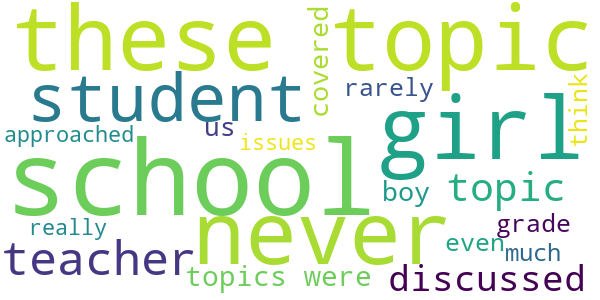

In [17]:
# Define a word cloud variable
cloud = WordCloud(background_color = "white", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5)

# Process the word cloud
cloud.generate(long_string)

# Visualize!
cloud.to_image()

In [214]:
sns.set(rc={'figure.figsize':(12,4.27)})
hr_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df, 
                         orient = "h")

NameError: name 'stop_df' is not defined

In [19]:
# How many topics?
n_topics = 5 
#Last time I tried, 10 was too much

In [20]:
# TfidfVectorizer to create the DTM
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,
                                   max_features = 5000,
                                   stop_words = "english")

# Fit
tfidf = tfidf_vectorizer.fit_transform(copy)

In [24]:
# Instantiate our LDA model
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                random_state = 5)
lda = lda.fit(tfidf)

In [25]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
print()

In [26]:
# Return the topics
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
school girls teachers really education health addressed spoken certain way taught pretty repercussions importance deemed financial mentality separate discrimination held

Topic #1:
students covered schools boys grade like approached discuss mental actually sports level class different touched seminars freely didnt menstruation care

Topic #2:
discussed sex topic rarely people discussions lot sexual went team surface allowed related considered teaching talked taboo time planning effort

Topic #3:
important teacher environment feel talking college weren used curriculum terms life faced sure good conducted roles believe religious opposed studied

Topic #4:
topics think dont issues things gender werent tried institution know problems open sessions given generally definitely wore explained interested mumbai


In [27]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "PCoA")
pyLDAvis.display(panel)

# Word2Vec

In [35]:
# First, store the documents we want to explore in a separate dataframe with just one column
w2v_df = pd.DataFrame({'Processed': survey["Text processed"]})
w2v_df

,Processed
0,in india mumbai it was introduced very briefly...
1,being in an allboys school i think they took t...
2,not well
3,it was a brief and short seminar that just hig...
4,schools merely did this in order to justify th...
...,...
107,we could go talk about it if we needed to but ...
108,issues like this were never addressed they wer...
109,they were rarely approached
110,topics such as mental health awareness and sex...


In [36]:
# Turn the text of each row into a list
# We now have a list of lists - one for each document
split_rows = [row.split() for row in w2v_df['Processed']]
split_rows

[['in',
  'india',
  'mumbai',
  'it',
  'was',
  'introduced',
  'very',
  'briefly',
  'and',
  'done',
  'in',
  'a',
  'manner',
  'that',
  'boys',
  'and',
  'girls',
  'had',
  'separate',
  'trainings',
  'this',
  'sort',
  'of',
  'defeated',
  'the',
  'point',
  'of',
  'normalizing',
  'sex',
  'related',
  'topics',
  'as',
  'we',
  'were',
  'not',
  'allowed',
  'to',
  'discuss',
  'it',
  'freely',
  'in',
  'la',
  'these',
  'topics',
  'were',
  'more',
  'normalized',
  'especially',
  'via',
  'mandatory',
  'trainings',
  'and',
  'online',
  'courses',
  'that',
  'had',
  'to',
  'be',
  'fulfilled',
  'prior',
  'to',
  'beginning',
  'freshman',
  'year',
  'courses'],
 ['being',
  'in',
  'an',
  'allboys',
  'school',
  'i',
  'think',
  'they',
  'took',
  'this',
  'pretty',
  'casually',
  'as',
  'it',
  'was',
  'so',
  'commonplace'],
 ['not', 'well'],
 ['it',
  'was',
  'a',
  'brief',
  'and',
  'short',
  'seminar',
  'that',
  'just',
  'highlig

In [37]:
no_stop = []
for response in split_rows:
    no_stop.append([word for word in response if word not in stop])
no_stop

[['india',
  'mumbai',
  'introduced',
  'briefly',
  'done',
  'manner',
  'boys',
  'girls',
  'separate',
  'trainings',
  'sort',
  'defeated',
  'point',
  'normalizing',
  'sex',
  'related',
  'topics',
  'allowed',
  'discuss',
  'freely',
  'la',
  'topics',
  'normalized',
  'especially',
  'via',
  'mandatory',
  'trainings',
  'online',
  'courses',
  'fulfilled',
  'prior',
  'beginning',
  'freshman',
  'year',
  'courses'],
 ['allboys', 'school', 'think', 'took', 'pretty', 'casually', 'commonplace'],
 ['well'],
 ['brief',
  'short',
  'seminar',
  'highlighted',
  'important',
  'points',
  'related',
  'topic',
  'discussed',
  'frankly',
  'sessions',
  'could',
  'conducted',
  'much',
  'better'],
 ['schools',
  'merely',
  'order',
  'justify',
  'inclusion',
  'nonacademic',
  'subjects',
  'curriculum',
  'without',
  'actually',
  'acknowledging',
  'importance',
  'teaching',
  'reflected',
  'inefficiency',
  'inability',
  'actually',
  'teach',
  'convey',
  

In [38]:
# Define the word2vec model
model = gensim.models.Word2Vec(no_stop, 
                               min_count = 2,
                               size = 12, 
                               workers = 3, 
                               window = 3, 
                               sg = 1)
#think the warning is because we aren't feeding it enough data

In [39]:
# Save the vocabulary 
words = list(model.wv.vocab)

In [40]:
model["bullying"]

array([-0.00549142, -0.01617467, -0.03974272,  0.03979076,  0.02560223,
        0.03063247,  0.01420305,  0.02144993, -0.00818829,  0.01200463,
       -0.01988887,  0.02487192], dtype=float32)

In [42]:
model.similarity("sex", "bullying")

0.31407514

# SO INTERESTING

In [43]:
model.wv.most_similar(negative = ["discussed", "topics", "sex"])

[('training', 0.6622839570045471),
 ('seminar', 0.6241304278373718),
 ('spoken', 0.6031779646873474),
 ('may', 0.5838195085525513),
 ('team', 0.5538907051086426),
 ('didnt', 0.5319873094558716),
 ('session', 0.5142983198165894),
 ('institution', 0.4972231686115265),
 ('class', 0.4798619747161865),
 ('females', 0.4677523374557495)]

In [44]:
model.wv.most_similar(negative = ["girls", "topics","sex"])

[('team', 0.6907954812049866),
 ('seminar', 0.6805852651596069),
 ('weren’t', 0.615662693977356),
 ('effort', 0.5414642095565796),
 ('part', 0.5392733812332153),
 ('lot', 0.5306826829910278),
 ('one', 0.5209740400314331),
 ('would', 0.4981568157672882),
 ('females', 0.4909101724624634),
 ('able', 0.47407299280166626)]

In [45]:
model.wv.most_similar(negative = ["girls", "school", "sex"])

[('seminars', 0.718041181564331),
 ('one', 0.6362630724906921),
 ('definitely', 0.6214616894721985),
 ('effort', 0.5907126069068909),
 ('part', 0.5789909362792969),
 ('manner', 0.5219936370849609),
 ('would', 0.49031004309654236),
 ('care', 0.4891936779022217),
 ('considered', 0.46566423773765564),
 ('clothes', 0.4575686454772949)]

In [47]:
model.wv.most_similar(negative = ["consensual", "sex", "school"])

[('one', 0.845820963382721),
 ('seminars', 0.7604743838310242),
 ('effort', 0.7182701826095581),
 ('care', 0.5804646611213684),
 ('short', 0.5614960193634033),
 ('maybe', 0.5596367120742798),
 ('spoke', 0.5230825543403625),
 ('it’s', 0.49993187189102173),
 ('authority', 0.4992695450782776),
 ('werent', 0.48531579971313477)]

In [48]:
# Save the word2vec vocab
features = model[model.wv.vocab]

In [49]:
# Define parameters of our PCA

# Just look at the first two dimensions - the X and Y axes
for_pca = PCA(n_components = 2)
pca_out = for_pca.fit_transform(features)

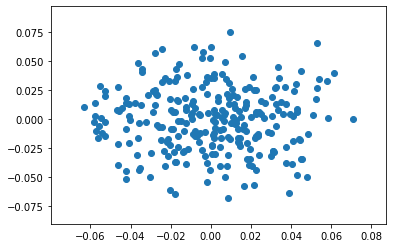

In [50]:
# Plot!
plt.scatter(pca_out[:, 0], pca_out[:, 1])